In [1]:
import torch
from datetime import datetime
import pytorch_lightning as pl
from pl_bolts.models.autoencoders import VAE
from pl_bolts.datamodules import CIFAR10DataModule, FashionMNISTDataModule, STL10DataModule, MNISTDataModule
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

In [2]:
from sklearn.decomposition import PCA
from tqdm import tqdm


def compute_eigenvalues(datamodule):
    dataloader = datamodule.train_dataloader()

    X_list = []
    for images, _ in tqdm(dataloader):
        # Flatten the images and center the data
        X = images.view(images.shape[0], -1)
        X_list.append(X)

    # Concatenate all batches
    X_all = torch.cat(X_list, dim=0).numpy()

    # Apply PCA
    pca = PCA()
    pca.fit(X_all)

    # Get the eigenvalues (explained variance)
    eigenvalues = pca.explained_variance_

    return eigenvalues

In [19]:
import numpy as np


def plot_eigenvalues(eigenvalues, ax, label=""):
    indices = np.arange(1, len(eigenvalues) + 1)  # Create an array of indices starting from 1
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]  # Sort eigenvalues in descending order

    # Fit a line to the top 99% of the eigenvalues with exponentially decreasing weights
    bulk = int(0.99 * len(eigenvalues))
    log_indices = np.log(indices[:bulk])
    log_eigenvalues = np.log(sorted_eigenvalues[:bulk])
    weights = np.diff(np.hstack([log_indices, log_indices[-1] + np.mean(np.diff(log_indices))]))
    slope, intercept = np.polyfit(log_indices, log_eigenvalues, 1, w=weights)

    # Plot the eigenvalues
    ax.loglog(indices, sorted_eigenvalues, '.-', label=f"{label} ({-slope:.3})", alpha=0.5)

    # Plot the fitted line
    ax.loglog(indices[:bulk], np.exp(intercept) * indices[:bulk] ** slope, 'k--')

    ax.set_xlabel('Index')
    ax.set_ylabel('Eigenvalue')
    if label:
        ax.legend()


    print(f"Slope coefficient for {label}: {slope}")

/tmp/ipykernel_4071127/1636555767.py:3: UnderReviewWarning: The feature STL10DataModule is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  datamodule = STL10DataModule(num_workers=1, data_dir="../../data", batch_size=32)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 2969/2969 [00:32<00:00, 92.01it/s]


Slope coefficient for STL10: -1.1747077562679478
Files already downloaded and verified
Files already downloaded and verified


  1%|          | 1/196 [00:00<02:22,  1.36it/s]ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
  2%|▏         | 4/196 [00:00<00:41,  4.59it/s]


RuntimeError: DataLoader worker (pid(s) 4081342, 4081349) exited unexpectedly

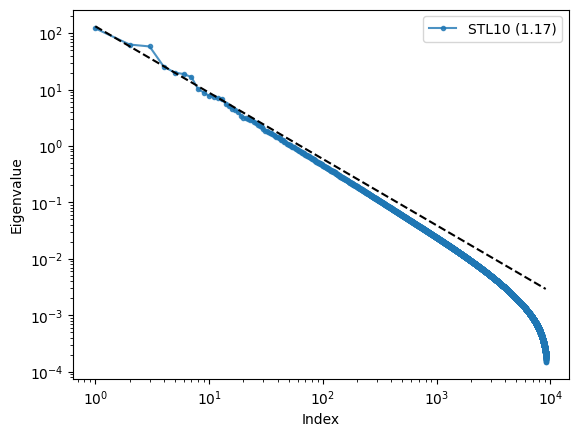

In [28]:
fig, ax = plt.subplots()

datamodule = STL10DataModule(data_dir="../../data", batch_size=32)
datamodule.train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])
datamodule.prepare_data()
datamodule.setup(stage=None)
eigenvalues = compute_eigenvalues(datamodule)
plot_eigenvalues(eigenvalues, ax, label='STL10')


datamodule = CIFAR10DataModule(data_dir="../../data", val_split=0, batch_size=256)
datamodule.train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])
datamodule.prepare_data()
datamodule.setup()
eigenvalues = compute_eigenvalues(datamodule)
plot_eigenvalues(eigenvalues, ax, label='CIFAR10')


datamodule = FashionMNISTDataModule(data_dir="../../data", val_split=0, batch_size=256)
datamodule.train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])
datamodule.prepare_data()
datamodule.setup()
eigenvalues = compute_eigenvalues(datamodule)
plot_eigenvalues(eigenvalues, ax, label='Fashion MNIST')

datamodule = MNISTDataModule(data_dir="../../data", val_split=0, batch_size=256)
datamodule.train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])
datamodule.prepare_data()
datamodule.setup()
eigenvalues = compute_eigenvalues(datamodule)
plot_eigenvalues(eigenvalues, ax, label='MNIST')


ax.set_ylim(1e-5, 1e3)
plt.show()

100%|██████████| 235/235 [00:01<00:00, 192.49it/s]


Slope coefficient for Dataset 1: -1.3534396418239107


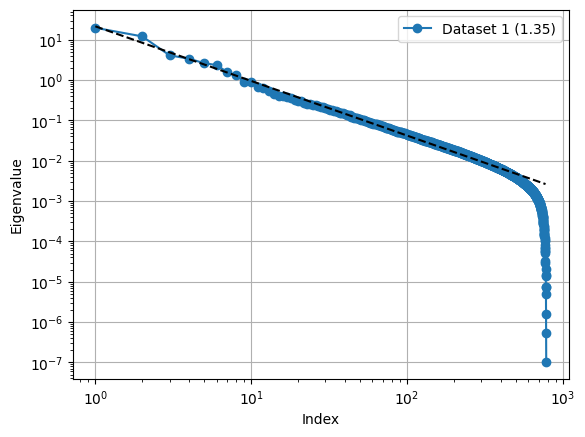

In [5]:

datamodule = FashionMNISTDataModule(num_workers=16, data_dir="../../data", val_split=0, batch_size=256)
datamodule.train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])
datamodule.prepare_data()
datamodule.setup()
eigenvalues = compute_eigenvalues(datamodule)
fig, ax = plt.subplots()
plot_eigenvalues(eigenvalues, ax, label='Dataset 1')


In [10]:
from torchvision import transforms
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization

cf10_transforms = transforms.Compose([transforms.ToTensor(), cifar10_normalization()])
dataset = CIFAR10(data_dir="../data", transform=cf10_transforms)

NameError: name 'CIFAR10' is not defined

6


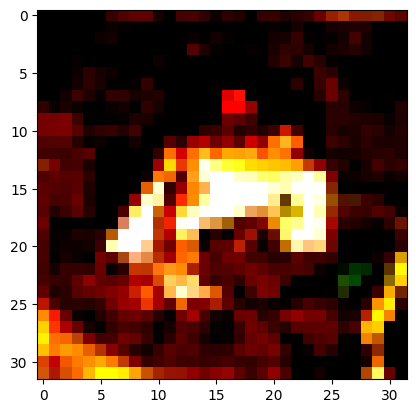

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

data, label = dataset[0]
print(label)
plt.imshow(np.transpose(data.numpy(), (1, 2, 0)))

In [ ]:
from sklearn.decomposition import PCA

# データセットをモノクロ化し平滑化
data_gray_flat = []

for img, _ in dataset:
    # グレースケールに変換
    img_gray = img.mean(dim=0)
    # 平滑化
    img_gray_flat = img_gray.view(-1)
    data_gray_flat.append(img_gray_flat.numpy())

data_gray_flat = np.array(data_gray_flat)

# PCAを適用
pca = PCA()
pca.fit(data_gray_flat)

# 分散を取得
explained_variance = pca.explained_variance_

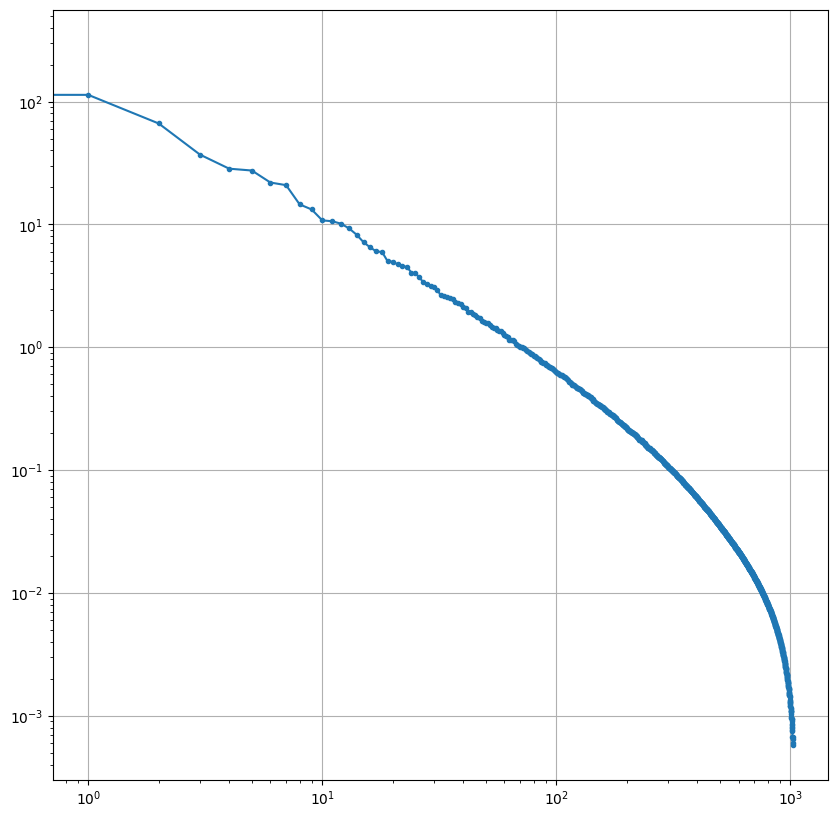

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ax.grid()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(explained_variance, ".-")

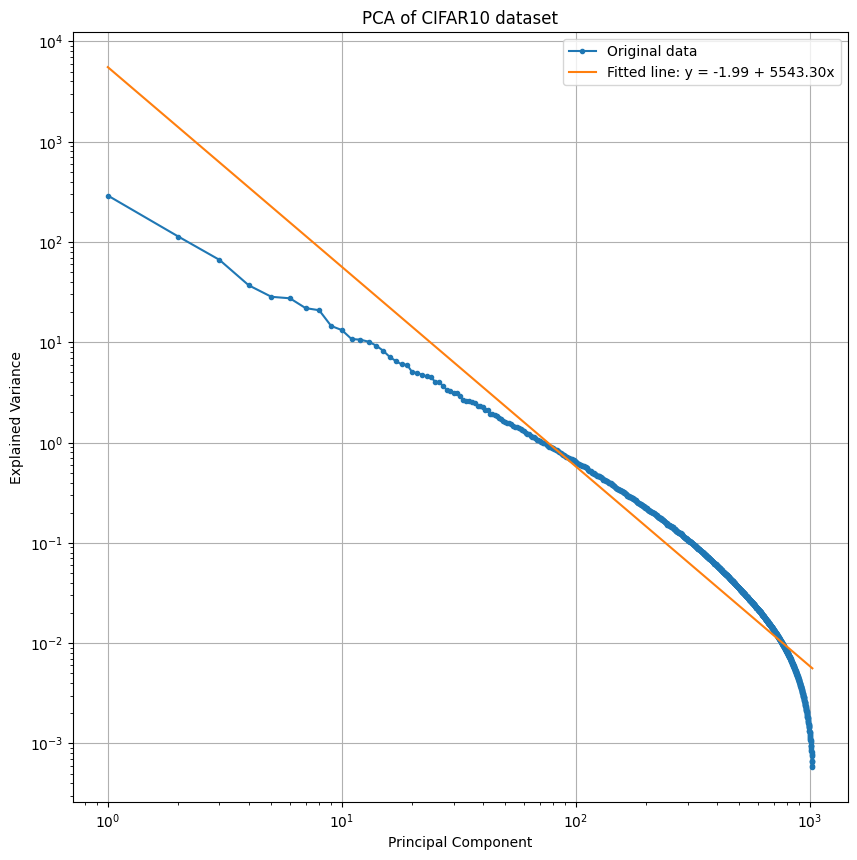

In [ ]:
# x軸の値を作成します (1, 2, 3, ...)
x = np.arange(1, len(explained_variance) + 1)

# データを対数スケールに変換します
log_x = np.log(x)
log_y = np.log(explained_variance)

# データを線形フィッティングします
b, lna = np.polyfit(log_x, log_y, deg=1)
a = np.exp(lna)

# プロットします
fig, ax = plt.subplots(figsize=(10, 10))
ax.grid()
ax.loglog(x, explained_variance, label="Original data", marker=".")
ax.loglog(x, a * x**b, label=f"Fitted line: y = {b:.2f} + {a:.2f}x")

plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.title("PCA of CIFAR10 dataset")
plt.legend()
plt.show()

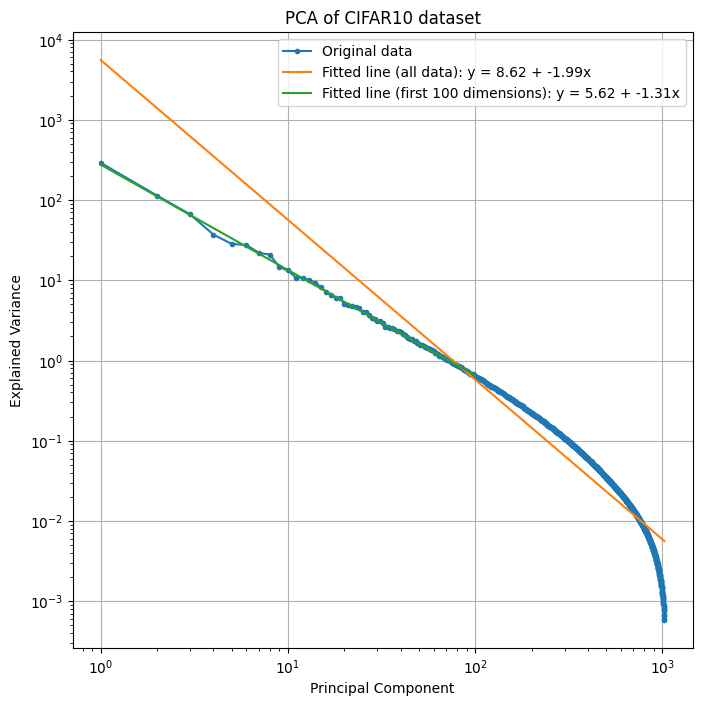

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# x軸の値を作成します (1, 2, 3, ...)
x = np.arange(1, len(explained_variance) + 1)

# データを対数スケールに変換します
log_x = np.log(x)
log_y = np.log(explained_variance)

# データ全体を線形フィッティングします
coeffs = np.polyfit(log_x, log_y, deg=1)
poly = np.poly1d(coeffs)

# 最初の90%のデータについて線形フィッティングを行います
percent = 90
n_percent = int(len(log_x) * percent * 0.01)
log_x_percent = log_x[:n_percent]
log_y_percent = log_y[:n_percent]
coeffs_percent = np.polyfit(log_x_percent, log_y_percent, deg=1)
poly_percent = np.poly1d(coeffs_percent)

# 最初の100次元について線形フィッティングを行います
n_cut = 100
log_x_cut = log_x[:n_cut]
log_y_cut = log_y[:n_cut]
coeffs_cut = np.polyfit(log_x_cut, log_y_cut, deg=1)
poly_cut = np.poly1d(coeffs_cut)

# プロットします
fig, ax = plt.subplots(figsize=(8, 8))
ax.grid()
ax.loglog(x, explained_variance, label="Original data", marker=".")
ax.loglog(
    x, np.exp(poly(log_x)), label=f"Fitted line (all data): y = {coeffs[1]:.2f} + {coeffs[0]:.2f}x"
)
# ax.loglog(x[:n_percent], np.exp(poly_percent(log_x_percent)), label=f'Fitted line (first {percent}% data): y = {coeffs_percent[1]:.2f} + {coeffs_percent[0]:.2f}x')
ax.loglog(
    x[:n_cut],
    np.exp(poly_cut(log_x_cut)),
    label=f"Fitted line (first {n_cut} dimensions): y = {coeffs_cut[1]:.2f} + {coeffs_cut[0]:.2f}x",
)

plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.title("PCA of CIFAR10 dataset")
plt.legend()
plt.show()

In [ ]:
log_x

array([0.        , 0.69314718, 1.09861229, ..., 6.92951677, 6.93049477,
       6.93147181])

In [ ]:
data, label = dataset[0]
data.size()

torch.Size([3, 32, 32])

In [ ]:
log_y

array([ 5.6720657,  4.7312765,  4.1946836, ..., -7.3412724, -7.4262447,
       -7.450703 ], dtype=float32)